In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
pd.options.display.max_columns = None
%matplotlib inline

from venn import venn

In [2]:
mutect_df = pd.read_csv("../genomic_data/Raw_MuTect2_ALL.csv", sep="\t")
sv_df = pd.read_csv("../genomic_data/Raw_SV_ALL.csv", sep="\t").drop_duplicates()
type_list = {'MUTECT':mutect_df, 'SV':sv_df}

In [3]:
samples = pd.read_csv("../data/samples/SAMPLES_Excel.tsv", sep="\t")
samples['label'] = samples.apply(lambda x: "T" if x['TMM'] == 'TEL' else "M"
                                 if (x['WestATRX'] == "Neg" or x['WestDAXX'] == "Neg") else "AP",
                                 axis=1)

In [4]:
samples = samples[samples['Mortal'].str.contains('JFCF')]

In [5]:
gene_list = ['ATRX', 'DAXX', 'TP53']
sample_list = np.concatenate(
    (samples['Immortal'].unique(), samples['Mortal'].unique()))
type_list = {'Somatic': mutect_df, 'SV': sv_df}
sv_df = sv_df[sv_df['Key'].str.contains('_Somatic')]

In [6]:
mapping = dict(zip(samples['Immortal'].values, samples['label'].values))
combined_df_all = pd.concat([mutect_df, sv_df])

In [7]:
df = combined_df_all[
    (combined_df_all['Name'] != 'JFCF_6_P_pLKO_5')
    & (combined_df_all['Impact'].isin(['HIGH', 'MODERATE']))
    & (combined_df_all['Name'].str.contains('JFCF'))].sort_values(
        by=['Key', 'Name'])

df = df.drop_duplicates(
    subset=df.columns.values[df.columns.values != 'Consequence'])
df = df.drop_duplicates(subset=['Key', 'Name'])

In [8]:
df_TEL = df[df['Name'].isin(samples[samples['TMM']=='TEL']['Immortal'])]
df_ALT = df[df['Name'].isin(samples[samples['TMM']=='ALT']['Immortal'])]

# ALT vs TEL mutations

In [9]:
mutations = {
    'TEL': set(df_TEL['Key']),
    'ALT': set(df_ALT['Key'])
}

Text(0.5, 1.0, 'TEL/ALT/Mortal Distinct Mutations')

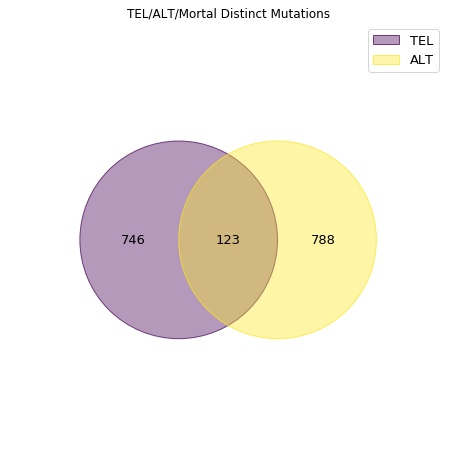

In [10]:
venn(mutations)
plt.title("TEL/ALT/Mortal Distinct Mutations")

In [17]:
res = pd.DataFrame({'Key':df['Key'].unique()})
for key, value in mutations.items():
    res[key] = res['Key'].map(lambda x:True if x in value else False)
key_gene = df.groupby(['Key','Gene','Consequence']).size().reset_index().drop([0], axis=1)

key_gene = key_gene.drop_duplicates("Key", keep='first')

res = pd.merge(res, key_gene, on=['Key'])

res = res.sort_values(by=['Gene','Key'])

In [15]:
res.to_csv("../results/mutations_TEL_ALT_somatic_highmoderate.tsv", index=False, sep="\t")

In [11]:
mutations_genes = {
    'TEL': set(df_TEL['Gene']),
    'ALT': set(df_ALT['Gene'])
}

Text(0.5, 1.0, 'TEL/ALT/Mortal Mutated Genes')

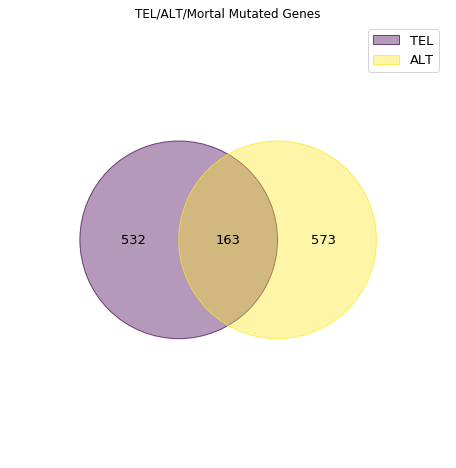

In [12]:
venn(mutations_genes)
plt.title("TEL/ALT/Mortal Mutated Genes")

In [28]:
tel_only = set(df_TEL['Key']) - set(df_ALT['Key'])
alt_only = set(df_ALT['Key']) - set(df_TEL['Key'])

In [22]:
alt_mutations = df[df['Key'].isin(alt_only)][['Gene', 'Name', 'Impact']].drop_duplicates().groupby(
    ['Gene']).size().sort_values(ascending=False).reset_index()

In [23]:
tel_mutations = df[df['Key'].isin(tel_only)][['Gene', 'Name', 'Impact']].drop_duplicates().groupby(
    ['Gene']).size().sort_values(ascending=False).reset_index()

In [21]:
alt_mutations.columns = ['Gene', 'count']
alt_mutations.to_csv("../results/alt_only_mutations_JFCF_only_somatic_highmoderate.tsv", index=False, sep='\t')

In [22]:
tel_mutations.columns = ['Gene', 'count']

tel_mutations.to_csv("../results/tel_only_mutations_JFCF_only_somatic_highmoderate.tsv", index=False, sep='\t')

Check TERT. It seems both ALT and TEL have TERT mutations.

In [23]:
samples[samples['Immortal'].isin(df[df['Gene']=='TERT']['Name'].unique())]

,Mortal,Immortal,TMM,WestATRX,WestDAXX,SWATH,label


In [24]:
df['Pos1'] = df['Pos1'].astype(str)

In [25]:
df[df['Gene']=='CBWD1'].sort_values(by=['Name'])

,Key,Name,Source,dbSNP,Type,Chr1,Pos1,Chr2,Pos2,Qual1,Qual2,AF1,AF2,Read1,Read2,Gene,Consequence,Impact,Ref1,Alt1,Ref2,Alt2


In [37]:
df.to_csv("../results/all_JFCF_mutations_details_no_plko_somatic_highmoderate.tsv", index=False, sep="\t")

In [28]:
df.head()

,Key,Name,Source,dbSNP,Type,Chr1,Pos1,Chr2,Pos2,Qual1,Qual2,AF1,AF2,Read1,Read2,Gene,Consequence,Impact,Ref1,Alt1,Ref2,Alt2
680725,IND_MuTect2_HIGH_AGAP3_chr7_150783901_GCT_G,JFCF_6_T_1J_1_3C,MuTect2,False,IND,chr7,150783901,NaN,NaN,5.11:-1.265,NaN,0.028,0.228,"[17, 0]","[8, 2]",AGAP3,frameshift_variant,HIGH,GCT,G,NaN,NaN
601109,IND_MuTect2_HIGH_AKAP12_chr6_151673338_CTG_C,JFCF_6_T_1_P_TEL,MuTect2,False,IND,chr6,151673338,NaN,NaN,17.75:-1.79,NaN,0.542,0.032,"[16, 19]","[59, 0]",AKAP12,frameshift_variant,HIGH,CTG,C,NaN,NaN
650491,IND_MuTect2_HIGH_AL160286.1_chr1_179457769_C_C...,JFCF_6_T_5K,MuTect2,False,IND,chr1,179457769,NaN,NaN,2.67:-1.186,NaN,0.323,0.326,"[9, 2]","[9, 0]",AL160286.1,frameshift_variant,HIGH,C,CTTTT,NaN,NaN
518547,IND_MuTect2_HIGH_ALPPL2_chr2_233273456_AC_A,JFCF_6_T_1_C,MuTect2,False,IND,chr2,233273456,NaN,NaN,4.52:-1.204,NaN,0.4,3.162e-05,"[3, 2]","[15, 0]",ALPPL2,frameshift_variant,HIGH,AC,A,NaN,NaN
574717,IND_MuTect2_HIGH_ARHGAP39_chr8_145770786_GGCAC...,JFCF_6_T_1_H,MuTect2,False,IND,chr8,145770786,NaN,NaN,6.92:-1.395,NaN,0.315,0.04,"[12, 5]","[23, 0]",ARHGAP39,frameshift_variant,HIGH,GGCACAGC,G,NaN,NaN


# All ALT & All TEL

In [25]:
df_ALT_genes = set(df_ALT['Gene'])
df_TEL_genes = set(df_TEL['Gene'])

In [26]:
df_ALT_no_mortal = df_ALT[df_ALT['Gene'].isin(df_ALT_genes)]
df_TEL_no_mortal = df_TEL[df_TEL['Gene'].isin(df_TEL_genes)]

In [27]:
df_ALT_no_mortal[['Name', 'Gene']].drop_duplicates().groupby(
    ['Gene']).size().sort_values(ascending=False).head(10)

Gene
AK5             9
ATRX            9
NKAIN2          9
FOXP1           9
OTUD7A          9
RP11-764K9.4    8
PPP3R1          8
PPP2R2B         8
RP4-610C12.1    8
GGCT            8
dtype: int64

In [37]:
df_TEL_no_mortal[['Name', 'Gene']].drop_duplicates().groupby(
    ['Gene']).size().sort_values(ascending=False).head(10)

Gene
EPHA3             8
AUTS2             8
RNGTT             7
CCDC178           7
LRRTM4            7
LSAMP             7
RSRC1             7
RP11-219A15.1     7
EVI5              7
XXbac-B33L19.3    7
dtype: int64

In [35]:
df_Mortal[df_Mortal['Gene']=='TERT'].drop_duplicates()

,Key,Name,Source,dbSNP,Type,Chr1,Pos1,Chr2,Pos2,Qual1,Qual2,AF1,AF2,Read1,Read2,Gene,Consequence,Impact,Ref1,Alt1,Ref2,Alt2
219078,SV_GRIDSS_HIGH_TERT_chr5_1276768_1276771_chr5_...,JFCF_6,GRIDSS,False,Deletion,chr5,1276768-1276771,chr5,1276822-1276825,NotSplit:17.64;Split:97.23,NotSplit:17.64;Split:97.23,NaN,NaN,NotSplit:1;Split:4,NotSplit:1;Split:4,TERT,gene_fusion,HIGH,A,A[CHR5:1276823[,C,]CHR5:1276769]C


In [5]:
df_TEL[df_TEL['Gene']=='TERT']

NameError: name 'df_TEL' is not defined

In [37]:
df_ALT[df_ALT['Gene']=='TERT']

,Key,Name,Source,dbSNP,Type,Chr1,Pos1,Chr2,Pos2,Qual1,Qual2,AF1,AF2,Read1,Read2,Gene,Consequence,Impact,Ref1,Alt1,Ref2,Alt2
356779,SV_GRIDSS_HIGH_TERT_chr5_1276768_1276771_chr5_...,JFCF_6_T_1J_11E,GRIDSS,False,Deletion,chr5,1276768-1276771,chr5,1276822-1276825,NotSplit:53.54;Split:277.19,NotSplit:53.54;Split:277.19,NaN,NaN,NotSplit:3;Split:11,NotSplit:3;Split:11,TERT,gene_fusion,HIGH,A,A[CHR5:1276823[,C,]CHR5:1276769]C
372153,SV_GRIDSS_HIGH_TERT_chr5_1276768_1276771_chr5_...,JFCF_6_T_1J_1_3C,GRIDSS,False,Deletion,chr5,1276768-1276771,chr5,1276822-1276825,NotSplit:17.64;Split:99.43,NotSplit:17.64;Split:99.43,NaN,NaN,NotSplit:1;Split:4,NotSplit:1;Split:4,TERT,gene_fusion,HIGH,A,A[CHR5:1276823[,C,]CHR5:1276769]C
280197,SV_GRIDSS_HIGH_TERT_chr5_1276768_1276771_chr5_...,JFCF_6_T_1_D,GRIDSS,False,Deletion,chr5,1276768-1276771,chr5,1276822-1276825,NotSplit:35.23;Split:169.48,NotSplit:35.23;Split:169.48,NaN,NaN,NotSplit:2;Split:7,NotSplit:2;Split:7,TERT,gene_fusion,HIGH,A,A[CHR5:1276823[,C,]CHR5:1276769]C
404497,SV_GRIDSS_HIGH_TERT_chr5_1276768_1276771_chr5_...,JFCF_6_T_1_L,GRIDSS,False,Deletion,chr5,1276768-1276771,chr5,1276822-1276825,NotSplit:35.57;Split:171.63,NotSplit:35.57;Split:171.63,NaN,NaN,NotSplit:2;Split:7,NotSplit:2;Split:7,TERT,gene_fusion,HIGH,A,A[CHR5:1276823[,C,]CHR5:1276769]C
219079,SV_GRIDSS_HIGH_TERT_chr5_1276768_1276771_chr5_...,JFCF_6_T_1_M,GRIDSS,False,Deletion,chr5,1276768-1276771,chr5,1276822-1276825,NotSplit:17.64;Split:97.23,NotSplit:17.64;Split:97.23,NaN,NaN,NotSplit:1;Split:4,NotSplit:1;Split:4,TERT,gene_fusion,HIGH,A,A[CHR5:1276823[,C,]CHR5:1276769]C
419035,SV_GRIDSS_HIGH_TERT_chr5_1276768_1276771_chr5_...,JFCF_6_T_1_P_ALT,GRIDSS,False,Deletion,chr5,1276768-1276771,chr5,1276822-1276825,NotSplit:17.64;Split:97.43,NotSplit:17.64;Split:97.43,NaN,NaN,NotSplit:1;Split:4,NotSplit:1;Split:4,TERT,gene_fusion,HIGH,A,A[CHR5:1276823[,C,]CHR5:1276769]C
233755,SV_GRIDSS_HIGH_TERT_chr5_1276768_1276771_chr5_...,JFCF_6_T_1_Q,GRIDSS,False,Deletion,chr5,1276768-1276771,chr5,1276822-1276825,NotSplit:17.64;Split:144.81,NotSplit:17.64;Split:144.81,NaN,NaN,NotSplit:1;Split:6,NotSplit:1;Split:6,TERT,gene_fusion,HIGH,A,A[CHR5:1276823[,C,]CHR5:1276769]C
449770,SV_GRIDSS_HIGH_TERT_chr5_1276768_1276771_chr5_...,JFCF_6_T_1_R,GRIDSS,False,Deletion,chr5,1276768-1276771,chr5,1276822-1276825,NotSplit:17.64;Split:151.02,NotSplit:17.64;Split:151.02,NaN,NaN,NotSplit:1;Split:6,NotSplit:1;Split:6,TERT,gene_fusion,HIGH,A,A[CHR5:1276823[,C,]CHR5:1276769]C
479141,SV_GRIDSS_HIGH_TERT_chr5_1276768_1276771_chr5_...,JFCF_6_T_5K,GRIDSS,False,Deletion,chr5,1276768-1276771,chr5,1276822-1276825,NotSplit:35.67;Split:125.09,NotSplit:35.67;Split:125.09,NaN,NaN,NotSplit:2;Split:5,NotSplit:2;Split:5,TERT,gene_fusion,HIGH,A,A[CHR5:1276823[,C,]CHR5:1276769]C


# TERT analysis

## promoter region (approx str search)

In [38]:
tert_promoter_region = ('chr5', '1293500', '1296500')

In [39]:
df_ALT[(df_ALT['Chr1'] == tert_promoter_region[0])
       & (((tert_promoter_region[1] <= df_ALT['Pos1'].astype(str)) &
           (df_ALT['Pos1'].astype(str) <= tert_promoter_region[2]))
          | ((tert_promoter_region[1] <= df_ALT['Pos2'].astype(str)) &
             (df_ALT['Pos2'].astype(str) <= tert_promoter_region[2])))]

,Key,Name,Source,dbSNP,Type,Chr1,Pos1,Chr2,Pos2,Qual1,Qual2,AF1,AF2,Read1,Read2,Gene,Consequence,Impact,Ref1,Alt1,Ref2,Alt2
356163,SNP_GATK_MODERATE_CHSY3_chr5_129521126_A_G,JFCF_6_T_1J_11E,GATK,True,SNP,chr5,129521126,NaN,NaN,1610.77,NaN,1,NaN,"[0, 38]",NaN,CHSY3,missense_variant,MODERATE,A,G,NaN,NaN
533144,SNP_GATK_MODERATE_CHSY3_chr5_129521126_A_G,JFCF_6_T_1J_1_3C,GATK,True,SNP,chr5,129521126,NaN,NaN,2501.77,NaN,1,NaN,"[0, 59]",NaN,CHSY3,missense_variant,MODERATE,A,G,NaN,NaN
383680,SNP_GATK_MODERATE_CHSY3_chr5_129521126_A_G,JFCF_6_T_1_D,GATK,True,SNP,chr5,129521126,NaN,NaN,1452.77,NaN,1,NaN,"[0, 35]",NaN,CHSY3,missense_variant,MODERATE,A,G,NaN,NaN
437494,SNP_GATK_MODERATE_CHSY3_chr5_129521126_A_G,JFCF_6_T_1_L,GATK,True,SNP,chr5,129521126,NaN,NaN,1201.77,NaN,1,NaN,"[0, 28]",NaN,CHSY3,missense_variant,MODERATE,A,G,NaN,NaN
560049,SNP_GATK_MODERATE_CHSY3_chr5_129521126_A_G,JFCF_6_T_1_M,GATK,True,SNP,chr5,129521126,NaN,NaN,977.77,NaN,1,NaN,"[0, 25]",NaN,CHSY3,missense_variant,MODERATE,A,G,NaN,NaN
464595,SNP_GATK_MODERATE_CHSY3_chr5_129521126_A_G,JFCF_6_T_1_P_ALT,GATK,True,SNP,chr5,129521126,NaN,NaN,1421.77,NaN,1,NaN,"[0, 33]",NaN,CHSY3,missense_variant,MODERATE,A,G,NaN,NaN
478182,SNP_GATK_MODERATE_CHSY3_chr5_129521126_A_G,JFCF_6_T_1_R,GATK,True,SNP,chr5,129521126,NaN,NaN,1494.77,NaN,1,NaN,"[0, 35]",NaN,CHSY3,missense_variant,MODERATE,A,G,NaN,NaN
505200,SNP_GATK_MODERATE_CHSY3_chr5_129521126_A_G,JFCF_6_T_5K,GATK,True,SNP,chr5,129521126,NaN,NaN,1368.77,NaN,1,NaN,"[0, 33]",NaN,CHSY3,missense_variant,MODERATE,A,G,NaN,NaN


In [40]:
df_TEL[(df_TEL['Chr1'] == tert_promoter_region[0])
       & (((tert_promoter_region[1] <= df_TEL['Pos1'].astype(str)) &
           (df_TEL['Pos1'].astype(str) <= tert_promoter_region[2]))
          | ((tert_promoter_region[1] <= df_TEL['Pos2'].astype(str)) &
             (df_TEL['Pos2'].astype(str) <= tert_promoter_region[2])))]

,Key,Name,Source,dbSNP,Type,Chr1,Pos1,Chr2,Pos2,Qual1,Qual2,AF1,AF2,Read1,Read2,Gene,Consequence,Impact,Ref1,Alt1,Ref2,Alt2
342665,SNP_GATK_MODERATE_CHSY3_chr5_129521126_A_G,JFCF_6_T_1J_11C,GATK,True,SNP,chr5,129521126,NaN,NaN,1754.77,NaN,1,NaN,"[0, 41]",NaN,CHSY3,missense_variant,MODERATE,A,G,NaN,NaN
546649,SNP_GATK_MODERATE_CHSY3_chr5_129521126_A_G,JFCF_6_T_1J_6B,GATK,True,SNP,chr5,129521126,NaN,NaN,2554.77,NaN,1,NaN,"[0, 60]",NaN,CHSY3,missense_variant,MODERATE,A,G,NaN,NaN
369825,SNP_GATK_MODERATE_CHSY3_chr5_129521126_A_G,JFCF_6_T_1_C,GATK,True,SNP,chr5,129521126,NaN,NaN,1458.77,NaN,1,NaN,"[0, 34]",NaN,CHSY3,missense_variant,MODERATE,A,G,NaN,NaN
397038,SNP_GATK_MODERATE_CHSY3_chr5_129521126_A_G,JFCF_6_T_1_F,GATK,True,SNP,chr5,129521126,NaN,NaN,896.77,NaN,1,NaN,"[0, 21]",NaN,CHSY3,missense_variant,MODERATE,A,G,NaN,NaN
410305,SNP_GATK_MODERATE_CHSY3_chr5_129521126_A_G,JFCF_6_T_1_G,GATK,True,SNP,chr5,129521126,NaN,NaN,733.77,NaN,1,NaN,"[0, 17]",NaN,CHSY3,missense_variant,MODERATE,A,G,NaN,NaN
423873,SNP_GATK_MODERATE_CHSY3_chr5_129521126_A_G,JFCF_6_T_1_H,GATK,True,SNP,chr5,129521126,NaN,NaN,996.77,NaN,1,NaN,"[0, 24]",NaN,CHSY3,missense_variant,MODERATE,A,G,NaN,NaN
450621,SNP_GATK_MODERATE_CHSY3_chr5_129521126_A_G,JFCF_6_T_1_P_TEL,GATK,True,SNP,chr5,129521126,NaN,NaN,2065.77,NaN,1,NaN,"[0, 47]",NaN,CHSY3,missense_variant,MODERATE,A,G,NaN,NaN
491678,SNP_GATK_MODERATE_CHSY3_chr5_129521126_A_G,JFCF_6_T_2H,GATK,True,SNP,chr5,129521126,NaN,NaN,1094.77,NaN,1,NaN,"[0, 27]",NaN,CHSY3,missense_variant,MODERATE,A,G,NaN,NaN


## promoter gene search

In [41]:
tert_promoters = [
    'ESR2', 'E2F4', 'TP53', 'SP1', 'RARB', 'HIF1A', 'FLI1', 'ETS2', 'ESR1',
    'MYC', 'WT1', 'USF2', 'USF1'
]

In [42]:
df_ALT_no_mortal[df_ALT_no_mortal['Gene'].isin(tert_promoters)]

,Key,Name,Source,dbSNP,Type,Chr1,Pos1,Chr2,Pos2,Qual1,Qual2,AF1,AF2,Read1,Read2,Gene,Consequence,Impact,Ref1,Alt1,Ref2,Alt2
240456,SV_GRIDSS_HIGH_HIF1A_chr14_62175564_62175565_c...,JFCF_6_T_1_Q,GRIDSS,False,Duplication,chr14,62175564-62175565,chr14,62176071-62176072,NotSplit:152.33;Split:125.11,NotSplit:152.33;Split:125.11,NaN,NaN,NotSplit:9;Split:4,NotSplit:9;Split:4,HIF1A,gene_fusion,HIGH,C,]CHR14:62176072]GGAAAATCGCTTGAACCTGGGAGGCGGAGG...,A,AGGAAAATCGCTTGAACCTGGGAGGCGGAGGTTGCAGTGAGCGGAG...
240458,SV_GRIDSS_HIGH_HIF1A_chr14_62175564_62175566_c...,JFCF_6_T_1_Q,GRIDSS,False,Duplication,chr14,62175564-62175566,chr14,62177722-62177724,NotSplit:158.99;Split:77.47,NotSplit:158.99;Split:77.47,NaN,NaN,NotSplit:9;Split:3,NotSplit:9;Split:3,HIF1A,gene_fusion,HIGH,T,]CHR14:62177724]T,C,C[CHR14:62175566[


In [43]:
df_TEL_no_mortal[df_TEL_no_mortal['Gene'].isin(tert_promoters)]

,Key,Name,Source,dbSNP,Type,Chr1,Pos1,Chr2,Pos2,Qual1,Qual2,AF1,AF2,Read1,Read2,Gene,Consequence,Impact,Ref1,Alt1,Ref2,Alt2


In [44]:
df_ALT[df_ALT['Gene'].isin(tert_promoters)].groupby(['Name']).size()

Name
JFCF_6_T_1J_11E     4
JFCF_6_T_1J_1_3C    4
JFCF_6_T_1_D        4
JFCF_6_T_1_L        4
JFCF_6_T_1_M        4
JFCF_6_T_1_P_ALT    4
JFCF_6_T_1_Q        2
JFCF_6_T_1_R        4
JFCF_6_T_5K         4
dtype: int64

In [45]:
df_ALT[df_ALT['Gene'].isin(tert_promoters)].groupby(['Gene']).size()

Gene
E2F4      8
ESR2     16
HIF1A     2
TP53      8
dtype: int64

In [46]:
df_TEL[df_TEL['Gene'].isin(tert_promoters)].groupby(['Name']).size()

Name
JFCF_6_T_1J_11C     4
JFCF_6_T_1J_6B      6
JFCF_6_T_1_C        4
JFCF_6_T_1_F        4
JFCF_6_T_1_G        3
JFCF_6_T_1_H        4
JFCF_6_T_1_P_TEL    4
JFCF_6_T_2H         4
dtype: int64

# remove different Chr for SV

In [72]:
df = df[~((df['Source']=='GRIDSS') & (df['Chr1']!=df['Chr2']))]

In [74]:
df_TEL = df[df['Name'].isin(samples[samples['TMM']=='TEL']['Immortal'])]
df_ALT = df[df['Name'].isin(samples[samples['TMM']=='ALT']['Immortal'])]
df_Mortal = df[df['Name'].isin(samples['Mortal'])]

In [76]:
df_Mortal_only = df_Mortal[df_Mortal['Key'].isin(
    list(set(df_Mortal['Key']) - set(df_TEL['Key']) - set(df_ALT['Key'])))]

In [75]:
df_Mortal[df_Mortal['Source']=='GRIDSS']

,Key,Name,Source,dbSNP,Type,Chr1,Pos1,Chr2,Pos2,Qual1,Qual2,AF1,AF2,Read1,Read2,Gene,Consequence,Impact,Ref1,Alt1,Ref2,Alt2
224554,SV_GRIDSS_HIGH_A2ML1_chr12_9016839_9016852_chr...,JFCF_6,GRIDSS,False,Deletion,chr12,9016839-9016852,chr12,9017867-9017880,NotSplit:765.84;Split:132.86,NotSplit:765.84;Split:132.86,NaN,NaN,NotSplit:42;Split:5,NotSplit:42;Split:5,A2ML1,gene_fusion,HIGH,T,T[CHR12:9017880[,A,]CHR12:9016852]A
228906,SV_GRIDSS_HIGH_A4GALT_chr22_43116246_43116247_...,JFCF_6,GRIDSS,False,Duplication,chr22,43116246-43116247,chr22,43116278-43116279,NotSplit:0;Split:52.69,NotSplit:0;Split:153.3,NaN,NaN,NotSplit:0;Split:2,NotSplit:0;Split:5,A4GALT,gene_fusion,HIGH,G,]CHR22:43116279]G,C,C[CHR22:43116247[
320054,SV_GRIDSS_HIGH_A4GALT_chr22_43116276_43116277_...,JFCF_6,GRIDSS,False,Insertion,chr22,43116276-43116277,chr22,43116277-43116278,NotSplit:17.97;Split:0,NotSplit:17.97;Split:0,NaN,NaN,NotSplit:1;Split:0,NotSplit:1;Split:0,A4GALT,gene_fusion,HIGH,C,CTCGCCCTTCCCGCTTCTGAGCAGGTCCAAATCT[CHR22:43116...,T,]CHR22:43116277]TCGCCCTTCCCGCTTCTGAGCAGGTCCAAA...
217717,SV_GRIDSS_HIGH_AADACL2-AS1&MIR548H2_chr3_15150...,JFCF_6,GRIDSS,False,Deletion,chr3,151503208-151503233,chr3,151503269-151503294,NotSplit:18.29;Split:170.67,NotSplit:18.29;Split:170.67,NaN,NaN,NotSplit:1;Split:7,NotSplit:1;Split:7,AADACL2-AS1&MIR548H2,bidirectional_gene_fusion,HIGH,A,A[CHR3:151503270[,A,]CHR3:151503209]A
293748,SV_GRIDSS_HIGH_AADACL2-AS1&MIR548H2_chr3_15150...,JFCF_6,GRIDSS,False,Insertion,chr3,151509098-151509099,chr3,151509099-151509100,NotSplit:0;Split:33.74,NotSplit:0;Split:33.74,NaN,NaN,NotSplit:0;Split:1,NotSplit:0;Split:1,AADACL2-AS1&MIR548H2,bidirectional_gene_fusion,HIGH,C,CTATTTTATGTATGTAAATTATATTTTATGTATGTAATTATATTA[...,T,]CHR3:151509099]TATTTTATGTATGTAAATTATATTTTATGT...
217716,SV_GRIDSS_HIGH_AADACL2-AS1_chr3_151503208_1515...,JFCF_6,GRIDSS,False,Deletion,chr3,151503208-151503233,chr3,151503269-151503294,NotSplit:18.29;Split:170.67,NotSplit:18.29;Split:170.67,NaN,NaN,NotSplit:1;Split:7,NotSplit:1;Split:7,AADACL2-AS1,gene_fusion,HIGH,A,A[CHR3:151503270[,A,]CHR3:151503209]A
293747,SV_GRIDSS_HIGH_AADACL2-AS1_chr3_151509098_1515...,JFCF_6,GRIDSS,False,Insertion,chr3,151509098-151509099,chr3,151509099-151509100,NotSplit:0;Split:33.74,NotSplit:0;Split:33.74,NaN,NaN,NotSplit:0;Split:1,NotSplit:0;Split:1,AADACL2-AS1,gene_fusion,HIGH,C,CTATTTTATGTATGTAAATTATATTTTATGTATGTAATTATATTA[...,T,]CHR3:151509099]TATTTTATGTATGTAAATTATATTTTATGT...
232393,SV_GRIDSS_HIGH_AADACL2-AS1_chr3_151571866_1515...,JFCF_6,GRIDSS,False,Duplication,chr3,151571866-151571867,chr3,151571925-151571926,NotSplit:0;Split:160.28,NotSplit:0;Split:160.28,NaN,NaN,NotSplit:0;Split:7,NotSplit:0;Split:7,AADACL2-AS1,gene_fusion,HIGH,A,]CHR3:151571926]GATA,T,TGAT[CHR3:151571867[
258249,SV_GRIDSS_HIGH_AATK_chr17_79113307_79113315_ch...,JFCF_6,GRIDSS,False,Duplication,chr17,79113307-79113315,chr17,79113359-79113367,NotSplit:0;Split:230.19,NotSplit:0;Split:230.19,NaN,NaN,NotSplit:0;Split:10,NotSplit:0;Split:10,AATK,gene_fusion&frameshift_variant,HIGH,C,]CHR17:79113360]C,G,G[CHR17:79113308[
365213,SV_GRIDSS_HIGH_AATK_chr17_79114453_79114457_ch...,JFCF_6,GRIDSS,False,Duplication,chr17,79114453-79114457,chr17,79114485-79114489,NotSplit:0;Split:170.89,NotSplit:0;Split:176.83,NaN,NaN,NotSplit:0;Split:7,NotSplit:0;Split:7,AATK,gene_fusion&frameshift_variant,HIGH,A,]CHR17:79114489]A,G,G[CHR17:79114457[


In [78]:
df_Mortal_only[df_Mortal_only['Source']=='GRIDSS']

,Key,Name,Source,dbSNP,Type,Chr1,Pos1,Chr2,Pos2,Qual1,Qual2,AF1,AF2,Read1,Read2,Gene,Consequence,Impact,Ref1,Alt1,Ref2,Alt2
259817,SV_GRIDSS_HIGH_ABCG1_chr21_43678065_43678121_c...,JFCF_6,GRIDSS,False,Deletion,chr21,43678065-43678121,chr21,43678262-43678318,NotSplit:164.47;Split:19,NotSplit:164.47;Split:19,NaN,NaN,NotSplit:9;Split:1,NotSplit:9;Split:1,ABCG1,gene_fusion,HIGH,C,C[CHR21:43678263[,C,]CHR21:43678066]C
258006,SV_GRIDSS_HIGH_ACACA_chr17_35542446_35542471_c...,JFCF_6,GRIDSS,False,Deletion,chr17,35542446-35542471,chr17,35542765-35542790,NotSplit:0;Split:170.35,NotSplit:0;Split:170.35,NaN,NaN,NotSplit:0;Split:7,NotSplit:0;Split:7,ACACA,gene_fusion,HIGH,T,T[CHR17:35542766[,C,]CHR17:35542447]C
245583,SV_GRIDSS_HIGH_ACTG2_chr2_74128663_74128682_ch...,JFCF_6,GRIDSS,False,Deletion,chr2,74128663-74128682,chr2,74128714-74128733,NotSplit:37.03;Split:1379.1,NotSplit:37.03;Split:1379.1,NaN,NaN,NotSplit:2;Split:58,NotSplit:2;Split:58,ACTG2,gene_fusion,HIGH,T,T[CHR2:74128715[,G,]CHR2:74128664]G
249686,SV_GRIDSS_HIGH_ADAMTS2_chr5_178641140_17864115...,JFCF_6,GRIDSS,False,Deletion,chr5,178641140-178641158,chr5,178641291-178641309,NotSplit:0;Split:84.21,NotSplit:0;Split:84.21,NaN,NaN,NotSplit:0;Split:4,NotSplit:0;Split:4,ADAMTS2,gene_fusion,HIGH,A,A[CHR5:178641309[,A,]CHR5:178641158]A
259867,SV_GRIDSS_HIGH_ADARB1_chr21_46529054_46529087_...,JFCF_6,GRIDSS,False,Deletion,chr21,46529054-46529087,chr21,46529222-46529255,NotSplit:18.48;Split:226.64,NotSplit:18.48;Split:226.64,NaN,NaN,NotSplit:1;Split:9,NotSplit:1;Split:9,ADARB1,gene_fusion,HIGH,T,T[CHR21:46529223[,G,]CHR21:46529055]G
250165,SV_GRIDSS_HIGH_ADGRB3_chr6_69741411_69741425_c...,JFCF_6,GRIDSS,False,Duplication,chr6,69741411-69741425,chr6,69741444-69741458,NotSplit:0;Split:119.7,NotSplit:0;Split:119.7,NaN,NaN,NotSplit:0;Split:6,NotSplit:0;Split:6,ADGRB3,gene_fusion,HIGH,C,]CHR6:69741458]C,T,T[CHR6:69741425[
256262,SV_GRIDSS_HIGH_ADPRHL1_chr13_114100302_1141003...,JFCF_6,GRIDSS,False,Deletion,chr13,114100302-114100309,chr13,114100555-114100562,NotSplit:36.38;Split:155.31,NotSplit:36.38;Split:155.31,NaN,NaN,NotSplit:2;Split:6,NotSplit:2;Split:6,ADPRHL1,gene_fusion&frameshift_variant,HIGH,G,G[CHR13:114100556[,G,]CHR13:114100303]G
254816,SV_GRIDSS_HIGH_AKAP3_chr12_4733974_4733975_chr...,JFCF_6,GRIDSS,False,Insertion,chr12,4733974-4733975,chr12,4733975-4733976,NotSplit:18.11;Split:0,NotSplit:18.11;Split:0,NaN,NaN,NotSplit:1;Split:0,NotSplit:1;Split:0,AKAP3,gene_fusion,HIGH,G,GGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGT[CHR12:4733976[,G,]CHR12:4733975]GTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTG
254656,SV_GRIDSS_HIGH_ALG9_chr11_111692881_111692908_...,JFCF_6,GRIDSS,False,Deletion,chr11,111692881-111692908,chr11,111693187-111693214,NotSplit:18.39;Split:125.98,NotSplit:18.39;Split:125.98,NaN,NaN,NotSplit:1;Split:5,NotSplit:1;Split:5,ALG9,gene_fusion,HIGH,G,G[CHR11:111693188[,C,]CHR11:111692882]C
257774,SV_GRIDSS_HIGH_ANKRD11_chr16_89545764_89545783...,JFCF_6,GRIDSS,False,Deletion,chr16,89545764-89545783,chr16,89546077-89546096,NotSplit:0;Split:126.26,NotSplit:0;Split:126.26,NaN,NaN,NotSplit:0;Split:5,NotSplit:0;Split:5,ANKRD11,gene_fusion,HIGH,G,G[CHR16:89546078[,C,]CHR16:89545765]C


In [81]:
df[df['Gene']=='USP3']

,Key,Name,Source,dbSNP,Type,Chr1,Pos1,Chr2,Pos2,Qual1,Qual2,AF1,AF2,Read1,Read2,Gene,Consequence,Impact,Ref1,Alt1,Ref2,Alt2
379879,SV_GRIDSS_HIGH_USP3_chr15_63873845_63873872_ch...,JFCF_6_T_1J_1_3C,GRIDSS,False,Deletion,chr15,63873845-63873872,chr15,63874135-63874162,NotSplit:0;Split:125.09,NotSplit:0;Split:125.09,NaN,NaN,NotSplit:0;Split:5,NotSplit:0;Split:5,USP3,gene_fusion,HIGH,G,G[CHR15:63874136[,G,]CHR15:63873846]G
257038,SV_GRIDSS_HIGH_USP3_chr15_63840200_63840209_ch...,JFCF_6,GRIDSS,False,Deletion,chr15,63840200-63840209,chr15,63840460-63840469,NotSplit:0;Split:238.02,NotSplit:0;Split:238.02,NaN,NaN,NotSplit:0;Split:10,NotSplit:0;Split:10,USP3,gene_fusion,HIGH,C,C[CHR15:63840469[,A,]CHR15:63840209]A
379877,SV_GRIDSS_HIGH_USP3_chr15_63873845_63873872_ch...,JFCF_6,GRIDSS,False,Deletion,chr15,63873845-63873872,chr15,63874135-63874162,NotSplit:0;Split:125.09,NotSplit:0;Split:125.09,NaN,NaN,NotSplit:0;Split:5,NotSplit:0;Split:5,USP3,gene_fusion,HIGH,G,G[CHR15:63874136[,G,]CHR15:63873846]G


In [82]:
df[df['Gene']=='ATRX']

,Key,Name,Source,dbSNP,Type,Chr1,Pos1,Chr2,Pos2,Qual1,Qual2,AF1,AF2,Read1,Read2,Gene,Consequence,Impact,Ref1,Alt1,Ref2,Alt2
52985,SNP_GATK_HIGH_ATRX_chrX_76938581_C_A,JFCF_6_T_1_P_ALT,GATK,False,SNP,chrX,76938581,NaN,NaN,322.77,NaN,0.5,NaN,"[4, 9]",NaN,ATRX,stop_gained,HIGH,C,A,NaN,NaN
489015,SV_GRIDSS_HIGH_ATRX_chrX_76783771_76783774_chr...,JFCF_6_T_5K,GRIDSS,False,Duplication,chrX,76783771-76783774,chrX,76840055-76840058,NotSplit:256.58;Split:114.96,NotSplit:256.58;Split:114.96,NaN,NaN,NotSplit:14;Split:4,NotSplit:14;Split:4,ATRX,gene_fusion&frameshift_variant,HIGH,T,]CHRX:76840058]T,T,T[CHRX:76783774[
459730,SV_GRIDSS_HIGH_ATRX_chrX_76788737_76788738_chr...,JFCF_6_T_1_R,GRIDSS,False,Deletion,chrX,76788737-76788738,chrX,76876903-76876904,NotSplit:186.78;Split:0,NotSplit:186.78;Split:0,NaN,NaN,NotSplit:10;Split:0,NotSplit:10;Split:0,ATRX,gene_fusion&frameshift_variant,HIGH,G,GTAGCTGGGATTAC[CHRX:76876904[,A,]CHRX:76788738]TAGCTGGGATTACA
414294,SV_GRIDSS_HIGH_ATRX_chrX_76795540_76795542_chr...,JFCF_6_T_1_L,GRIDSS,False,Deletion,chrX,76795540-76795542,chrX,76940486-76940488,NotSplit:237.43;Split:213.13,NotSplit:237.43;Split:213.13,NaN,NaN,NotSplit:13;Split:8,NotSplit:13;Split:8,ATRX,gene_fusion,HIGH,T,T[CHRX:76940487[,C,]CHRX:76795541]C
489017,SV_GRIDSS_HIGH_ATRX_chrX_76798390_76798391_chr...,JFCF_6_T_5K,GRIDSS,False,Deletion,chrX,76798390-76798391,chrX,76799297-76799298,NotSplit:256.58;Split:129.98,NotSplit:256.58;Split:129.98,NaN,NaN,NotSplit:14;Split:7,NotSplit:14;Split:7,ATRX,gene_fusion,HIGH,T,T[CHRX:76799298[,G,]CHRX:76798391]G
243523,SV_GRIDSS_HIGH_ATRX_chrX_76808603_76808606_chr...,JFCF_6_T_1_Q,GRIDSS,False,Deletion,chrX,76808603-76808606,chrX,76875533-76875536,NotSplit:141.33;Split:96.28,NotSplit:141.33;Split:96.28,NaN,NaN,NotSplit:8;Split:4,NotSplit:8;Split:4,ATRX,gene_fusion&frameshift_variant,HIGH,C,C[CHRX:76875536[,C,]CHRX:76808606]C
367074,SV_GRIDSS_HIGH_ATRX_chrX_76853017_76853018_chr...,JFCF_6_T_1J_11E,GRIDSS,False,Deletion,chrX,76853017-76853018,chrX,77014863-77014864,NotSplit:239.32;Split:302.85,NotSplit:239.32;Split:302.85,NaN,NaN,NotSplit:13;Split:12,NotSplit:13;Split:12,ATRX,gene_fusion&frameshift_variant,HIGH,A,A[CHRX:77014864[,A,]CHRX:76853018]A
383255,SV_GRIDSS_HIGH_ATRX_chrX_76853017_76853018_chr...,JFCF_6_T_1J_1_3C,GRIDSS,False,Deletion,chrX,76853017-76853018,chrX,77014863-77014864,NotSplit:343.72;Split:285.82,NotSplit:343.72;Split:285.82,NaN,NaN,NotSplit:19;Split:11,NotSplit:19;Split:11,ATRX,gene_fusion&frameshift_variant,HIGH,A,A[CHRX:77014864[,A,]CHRX:76853018]A
290331,SV_GRIDSS_HIGH_ATRX_chrX_76862268_76862269_chr...,JFCF_6_T_1_D,GRIDSS,False,Deletion,chrX,76862268-76862269,chrX,77034579-77034580,NotSplit:249.27;Split:0,NotSplit:249.27;Split:0,NaN,NaN,NotSplit:14;Split:0,NotSplit:14;Split:0,ATRX,gene_fusion&frameshift_variant,HIGH,A,AGGTA[CHRX:77034580[,T,]CHRX:76862269]GGTAT
229105,SV_GRIDSS_HIGH_ATRX_chrX_76885052_76885055_chr...,JFCF_6_T_1_M,GRIDSS,False,Duplication,chrX,76885052-76885055,chrX,76923999-76924002,NotSplit:204.12;Split:318.66,NotSplit:204.12;Split:318.66,NaN,NaN,NotSplit:11;Split:12,NotSplit:11;Split:12,ATRX,gene_fusion&frameshift_variant,HIGH,A,]CHRX:76924002]A,G,G[CHRX:76885055[


# chrV

In [39]:
df[(df['Chr1']=='chrV') | (df['Chr2']=='chrV')]

,Key,Name,Source,dbSNP,Type,Chr1,Pos1,Chr2,Pos2,Qual1,Qual2,AF1,AF2,Read1,Read2,Gene,Consequence,Impact,Ref1,Alt1,Ref2,Alt2
